In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal
from scipy.special import gammaln,gamma
from math import log, floor, exp

### Background info

#### Shortcomings of sliding Windowed Fourier Transforms (Kaiser - 1994)
- WFT represents an inaccurate and inefficient method of time–frequency localisation - it imposes a “response interval” T into the analysis
- inaccuracy arises from the aliasing of high- and low-frequency components that do not fall within the frequency range of the window
- predetermined scaling may not be appropriate when dealing with a wide range of dominant frequencies

<br>

***Wavelet transform (WT)***
- can be used to analyse time series that contains nonstationary power at many different frequencies (Daubechies 1990), given that wavelets used can be scaled and translated


- general form of the wavelet transform (more efficient when computed in the spectral space):

${ W(t,s) = \int \frac{1}{s}\psi \big(\frac{\tau - t}{s} \big) z(\tau)  d\tau = \frac{1}{2\pi} \int_{-\infty}^{\infty}\psi*(s\omega) Z(\omega) e^{i\omega t} dt }$

where $\hat{\psi}*(s\omega)$ is the scaled daughter wavelet and $Z(\omega)$ is the signal, both in Fourier space

#### What is a wavelet?

- Function that has zero mean and is localised in both time and frequency (admissibility condition - Farge 1992)


- *In the time domain* - Oscillatory, time-localised function
- Complex exponential multiplied by a Gaussian (Morlet wavelet)
    - The complex exponential generates the oscillation
    - The Gaussian controls the time localisation
    
    
- *In the frequency domain* - bandpass filter

- For continuous wavelet transforms (CWT), non-orthogonal wavelet analysis ensures high redundancy to capture evolution of the oscillatory signals


- The continuous wavelet transform isometrically transforms a function of n variables into, an (n+ 1) dimensional wavelet space (wavelet transform)


#### Morse wavelet - unifies different wavelet types
- superfamily of analytic wavelets (complex valued wavelets - can analyse both amplitude and phase) 
- in the time-domain: wavelet is complex valued
- in freq. domain: wavelet vanishes for negative frequencies, one-sided bandpass filter making real valued signal complex (analytic signal method)
- aim of Morse is to generate a set of orthogonal wavelets (defined by $\kappa$) to create a set of scaleograms that can be averaged together to generate a low variance scaleogram estimate

#### Generalised Morse defined as:
Morse defined as:

${\psi_{\beta,\gamma}(\omega)}  =  \int_{-\infty}^{\infty} \psi_{\beta,\gamma}(t)e^{-i\omega t} dt  =  U(\omega) a_{\beta,\gamma} \omega^{\beta}e^{-\omega^{\gamma}}$

- ${U(\omega)}$: Heaviside step function
- $a_{\beta,\gamma}$: real valued normalising constant ($a_{\beta,\gamma} = 2 \big( \frac{e\gamma}{\beta} \big)^{\frac{\beta}{\gamma}}$, where $e$ is the Euler number)
- $\beta$ and $\gamma$ controls the wavelet shape

#### Wavelet parameters
- ${\gamma}$: family - controls the high frequency decay
    - ${\gamma = 3}$ closely approximate a Gaussian while remaining exactly analytic (similar to Morlet but without the short comings)

<br>
- ${\beta}$: order - controls the behaviour near the zero frequency
    - increasing $\beta$ causes wavelet to be more oscillatory in the time domain and the bandpass filter to be narrower in the frequency domain
    - ${\beta}$ controls the trade off between time resolution against frequency resolution
    
<br>

- additional parameter - $\kappa$: can compute multiple orthogonal versions of the generalized Morse wavelets, characterised by the order $\kappa$ (here we usually stick to the first order family but higher orders can also be computed)

### Steps for computing wavelet transform
#### Preparing data before applying wavelet - Boundary conditions 

- zeros: extends the time series with zeros at both edges (currently in use)
- periodic: wraps the beginning around to the end, and vice versa
- mirror: reflects the time series about the beginning and the end
- reverse: is like mirror, but with a change in sign, and a shift to make the time series be continuous at both edges


- **"mirror" boundary conditions usually yields better results - need to implement**


In [3]:
#apply boubdary conditions to data before transform 
#here as zero padding (no detrending of data) - need to implement periodic data 

def zero_pad(x):
    
    #get original length of data
    sizex = np.size(x)
    M=sizex
    
    #get index of first and last value of original data 
    #need to change to account for NaNs in data (e.g where there is topo)
    
    a = 0
    b=len(x)
    
    y = np.zeros(sizex*3)
    
    index=np.arange(a,b)
    indexy= np.arange(M+a-len(index), M + (2*len(index)) + a)
    
    #pad with zeros 
    y[indexy] = np.concatenate((0*x,x,0*x))
    
    return(y)


### Defining the wavelet's properties (by defining $\gamma$ and $\beta$)

#### Wavelet's time-domain width or wavelet duration $({P_{\beta,\gamma}})$
- ${P^2_{\beta,\gamma} = \beta \gamma}$
- ${P^2_{\beta,\gamma}/\pi}$ is the number of oscillations at the
peak frequency that fit within the central window of the time-domain
wavelet
- Different combination of $\gamma$ and $\beta$ can give the same ${P_{\beta,\gamma}}$ (Lilly,2012 - Figure 2)


In [4]:
# compute dimensionless time-domain window width (p) 
def morseprops(ga,be):
    p = np.sqrt(be*ga)
    skew = (ga-3)/p
    kurt = (3-skew)**2 - (2/p**2)
    
    return(p)


#### Wavelet peak frequency 
- maximum point of the frequency-domain wavelet
- derivative of ${\psi_{\beta,\gamma}(\omega)}$ with respect to $\omega$ vanishes
- ${\omega_{\beta,\gamma}} = \big(\frac{\beta}{\gamma}\big)^{\frac{1}{\gamma}}$

In [5]:
#compute modal or peak frequency
def morsefreq(ga,be):  
    if be==0:
        fm = log(2)**(1/ga)
        
    else:
        fm = np.exp((1/ga)*(log(be) - log(ga)))
        
    return(fm)


#### Wavelet footprint
- measure of the duration of the scale s wavelet
- ${L_{\beta,\gamma}(s) = 2\sqrt{2}\frac{P_{\beta,\gamma}}{\omega_{\beta,\gamma}}s}$
- window of this width captures ${\sim 95\%}$ of the total wavelet energy
- ${L_{\beta,\gamma}}$ is related to the scale s wavelet’s dimensional time-domain standard deviation - Lilly (2017) Appendix B

In [6]:
def morse_footprint(ga,be,s):
    p = morseprops(ga,be)
    fm = morsefreq(ga,be)
    
    L = 2*np.sqrt(2)*(p/fm)*s
    
    return(L)

#### Choosing frequency scales 

<br>
*** In general:
- Highest resolvable frequency - Nyquist frequency where: 
- $\omega_N = \pi/\Delta$ (one cycle should fit in $2\Delta$)


- Lowest resolvable frequency - Rayleigh frequency  where:
- $\omega_R = 2\pi/N\Delta$ (one cycle should fit in $N\Delta$)
    
    
- Nyquist to Rayleigh frequencies gives number of frequencies that can be resolved:
- ($\frac{N\Delta/2\pi}{\pi/\Delta} = \frac{N}{2}$)

<br>

***Default/computed values used in this case (as per Lilly (2017) - Appendix C)***:
- frequencies are in radians per sample point
- fs denotes the frequencies at the which Fourier transform of the wavelets reach their maximum
- sampling interval ($\Delta$) is always unity and is in terms of the scaling frequencies rather than frequencies. Sampling interval and cycles  are factored after


- High frequency cutoff ($\omega_{high}$): the highest possible radian frequency for which the wavelet will have a value no greater than (defined) $\eta$ times its maximum value at the Nyquist ($\omega_N$)
 
 
- Low frequency cutoff: ${\omega_{low} =p2\sqrt{2}\frac{P_{\beta,\gamma}}{M}}$
- where $p$ is the packing number specifying the number of wavelet footprints that span the length of the time series M 
- in default setting, $p$ is set to 5

<br>

***Wavelet density***:
- D determines the number of points in the frequency scales array - higher values of D mean more overlap in the frequency domain
- D=1, the peak of one wavelet is located at the half-power points 
of the adjacent wavelet. D=4 means that four other wavelets will occur between the peak of one wavelet and its half-power point
- Default value is set to D=4 

In [7]:
# compute highest frequency cutoff
def morsehigh(ga,be,eta):
    
    N = 10000;
    omhigh = np.linspace(0,np.pi,N)
    
    f = 0*ga
    om = morsefreq(ga,be)*np.pi/omhigh
    
    #use logs to avoid errors for really small gammas
    lnpsi1 = (be/ga) * np.log((exp(1)*ga)/be)
    lnpsi2 = be*np.log(om) - om**ga
    lnpsi = lnpsi1 + lnpsi2
    index = np.argwhere(log(eta) - lnpsi < 0)[0]

    fmax = omhigh[index]
    
    return(fmax)
    
        

In [8]:
# compute low frequency cutoff (eqn c3 in Lilly 2017)
def morsespace_low(ga,be,r,N):
    
    p = morseprops(ga,be);
    fmin = (2*np.sqrt(2)*p*r)/N
    
    return(fmin)


In [9]:
# generates frequency array for the generalised Morse array 
# fs has units of radians per sample point (frequency resolution is compatible with the bandwidth)

def morsespace(ga,be,N,D):
    low=(5,N) #5 is the packing number (p) 
    high=(0.1,np.pi)
    #D = 4     

    fhigh = min(high[1],morsehigh(ga,be,high[0]))
    flow = max(0,morsespace_low(ga,be,low[0],low[1]))
     
    r = 1 + (1/(D*morseprops(ga,be)))
    N = floor((log(fhigh/flow))/(log(r)))
    fs = fhigh*np.ones((N+1))/(r**np.arange(0,N+1))
    
    return(fs)



#### Converting scales to frequency scales
***In general***
- relationship between the equivalent Fourier period and the wavelet scale can be derived analytically for a particular wavelet function 
- Relationship between the wavelet scales and the Fourier period for different wavelet functions is defined in Torrence and Compo, 1998 (Table 1)

***Morse wavelet***
- rescaled frequency-domain wavelet $\psi_{\beta,\gamma} (s\omega)$ obtains maximum/has a peak at 
${\omega_s = \omega_{\beta,\gamma}/s}$
- need to factor in sampling interval given that ${\Delta}$ is assumed to be 1


In [652]:
def frequency_to_period(dt,fs):
    t = dt/(fs/(2*np.pi))      
    
    return(t)
    

#### Normalisation 

- Wavelet transform should be weighted only by the amplitude of the Fourier coefficients ${\hat{x}_k}$ and not by the wavelet function


- To ensure that the WT at each scale s are directly comparable to each other and to the transforms of other time series, the wavelet function at each scale s is normalised to have unit energy


- Different wavelet types have different normalising constant factors
    - check Table 1 in Torrence and Compo, 1998


- **For Morse - as described in Lilly (2017) and used hereunder** 
- ***Bandpass normalisation***: normalising factor ${(a_{\beta,\gamma})}$ set so that the peak value of the frequency domain wavelet is ${\psi_{\beta,\gamma}(\omega_{\gamma,\beta})=2}$, unit amplitude normalisation


- ***Energy normalisation***: returns the coefficient giving the wavelet unit energy. The time-domain wavelet energy ${(\psi_{\beta,\gamma}(t))}$ is then always unity and is more appropriate for the modulus-squared wavelet transform to reflect the energy of the analysed signal

In [11]:
#Returns the generalized Morse wavelet amplitude or a-function.

def morseafun(k,ga,be,str):
    
    if str == "ban":
        #amplitude using bandpass normalisation
        om=morsefreq(ga,be)
        a=(2)/(np.exp(be)*np.log(om) - om**ga)
    
    elif str == "ene":
        #amplitude using energy normalisation
        r = (2*be+1)/ga
        a = (2*np.pi*ga*(2**r)*np.exp(gammaln(k) - gammaln(k+r-1)))**0.5

    return(a)


#### Compute wavelet in the frequency domain (same size as data)
- Equation is from Olhede and Walden (2002), eqn 10 
- properties of gamma function used for easier computation
- wavelet in time domain then computed as an inverse Fourier operation ***still need to check if that gives a complex valued signal - yes it does, see below***


In [12]:
#generalised laguerre polynomial 
#as from Olhede and Walden (2002) - gamma function just below eqn (10) 
#log of gamma works better apparently in matlab, not sure about python

def laguerre(x,k,c):
    
    for m in np.arange(0,k+1):
        coeff_exp = gammaln(k+c+1) - gammaln(c+m+1) - gammaln(k-m+1);
        fact = np.exp(coeff_exp)
        y = ((-1)**m)*fact*(x**m)/gamma(m+1) 
        
    return(y)
        

In [13]:
#computes the standard geheralised Morse wavelet (primary wavelet)
#takes in psizero (when omega=0)
def morsewave_first_family(fact,N,K,ga,be,om,psizero,str):
    
    #small k as specified in Lilly (here k=0, when K=1)
    k = K-1
    
    r = (2*be+1)/ga
    c = r-1
    L = 0*om
    index = np.arange(0,int(N/2)+1) #only need to take half (something will be flipped after??)

    if str == "ene":
        A = morseafun(k+1,ga,be,str)
        coeff = np.sqrt(1/fact)*A
    
    elif str == "ban":
        if be == 0:
            coeff = 1
        
        else:
            coeff = np.sqrt(exp(gammaln(r)+ gammaln(k+1) - gammaln(k+r)))
        
    L[index] = laguerre(2*om[index]**ga,k,c) 
    psif  = coeff * psizero * L
    
    return(psif)


In [14]:
#computes primary Morse wavelet in frequency domain using equation (10) of Olhede 
#takes in one frequency/scale (fs is scalar) at a time
def morsewave_fs(N,K,ga,be,fs,str):
    fo = morsefreq(ga,be)
    fact = fs/fo
    om = 2*np.pi*np.linspace(0,1-(1/N),N)/fact

    #compute psizero that should be of length N
    #energy normalisation
    if str == "ene":
        if be == 0:
            psizero = np.exp(-om**ga)
        
        else:
            psizero = np.exp(be*np.log(om) - om**ga)
        
    #bandpass normalisation 
    elif str == "ban":
        if be == 0:
            psizero = np.exp(-om**ga)
        
        else:
            #calculation for preventing things from blowing up apparently 
            psizero = 2 * np.exp(-be* np.log(fo) + fo**ga + be*np.log(om) - om**ga)
            
    psif_fs = morsewave_first_family(fact,N,K,ga,be,om,psizero,str)
    
    return(psif_fs)

    

In [15]:
#computes primary Morse wavelet in frequency domain using equation (10) of Olhede 
#takes in all scales at a time (fs is an array of scales)
def morsewave(N,K,ga,be,fs,str):
    
    psif = np.zeros((N,len(fs)))
    
    for ii, fs_sel in enumerate(fs):
        psif_fs = morsewave_fs(N,K,ga,be,abs(fs_sel),str)
        psif[:,ii] = psif_fs
        
    return(psif)


#### Varying properties (${\beta,\gamma,D}$) for frequency-domain wavelet 
- note one sided bandpass (there should be support on negative frequencies or vice versa)
- note amplitude of wavelet for different normalisation



/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in subtract
  if sys.path[0] == '':
/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  
/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log


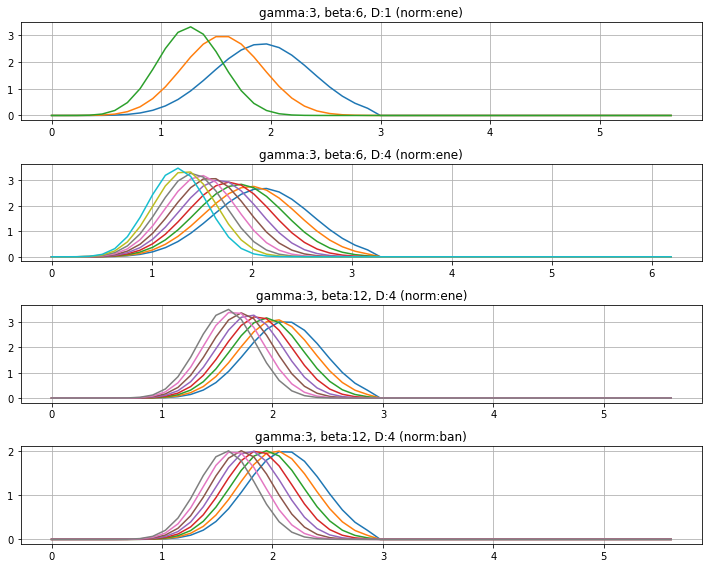

In [237]:
N=50; K=1; 
ga=3; be=6; D=1
str="ene"

fs = morsespace(ga,be,N,D)
fo = morsefreq(ga,be)
fact = fs/fo
om = 2*np.pi*np.linspace(0,1-(1/N),N)/fact[-1]

psif  = morsewave(N,K,ga,be,fs,str)

fig, ax = plt.subplots(4,1,figsize=(10, 8))
ax[0].plot(om,psif)
ax[0].grid()
ax[0].set_title("gamma:{}, beta:{}, D:{} (norm:{})".format(ga,be,D,str))

ga=3; be=6; D=4
str="ene"

fs = morsespace(ga,be,N,D)
fo = morsefreq(ga,be)
fact = fs/fo
om = 2*np.pi*np.linspace(0,1-(1/N),N)/fact[-1]

psif  = morsewave(N,K,ga,be,fs,str)

ax[1].plot(om,psif)
ax[1].grid()
ax[1].set_title("gamma:{}, beta:{}, D:{} (norm:{})".format(ga,be,D,str))

ga=3; be=12; D=4
str="ene"
fs = morsespace(ga,be,N,D)
fo = morsefreq(ga,be)
fact = fs/fo
om = 2*np.pi*np.linspace(0,1-(1/N),N)/fact[-1]

psif  = morsewave(N,K,ga,be,fs,str)

ax[2].plot(om,psif)
ax[2].grid()
ax[2].set_title("gamma:{}, beta:{}, D:{} (norm:{})".format(ga,be,D,str))

ga=3; be=12; D=4
str="ban"
fs = morsespace(ga,be,N,D)
fo = morsefreq(ga,be)
fact = fs/fo
om = 2*np.pi*np.linspace(0,1-(1/N),N)/fact[-1]
psif  = morsewave(N,K,ga,be,fs,str)

ax[3].plot(om,psif)
ax[3].grid()
ax[3].set_title("gamma:{}, beta:{}, D:{} (norm:{})".format(ga,be,D,str))

plt.tight_layout()
plt.show()

### Inverse transform of frequency-domain wavelet gives wavelet in time domain
- Before taking inverse, ensure that the wavelets are centred 
- Here using a complex valued rotation (for centering) prior to taking ifft - *** just copied from jLab, need to review why but seems to work***
- wavelet in time-domain is not needed in analysis given that computation is done in frequency domain (although for large scales, convolution in time domain might be better, more info in Kirby,2013)

/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in subtract
  if sys.path[0] == '':
/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  
/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log


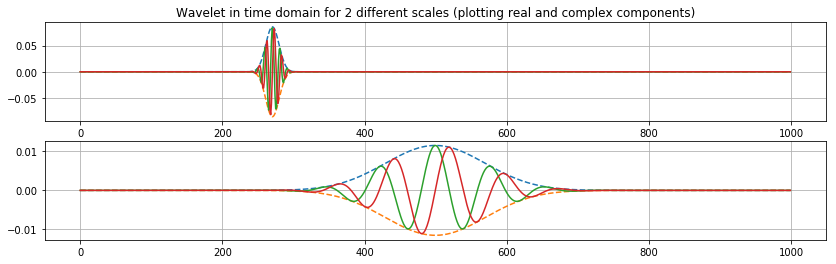

In [657]:
N=1000
ga=3; be=10; D=4
str="ban"
fs = morsespace(ga,be,N,D)
fo = morsefreq(ga,be)
fact = fs/fo
om = 2*np.pi*np.linspace(0,1-(1/N),N)/fact[-1]

psif  = morsewave(N,K,ga,be,fs,str)

ss=30
rot_values = np.exp(1j*(om*((N+1)/2)*fact[ss]))
psif_rot = psif[:,ss]*rot_values
psi = np.fft.ifft(psif_rot)

fig, ax = plt.subplots(2,1,figsize=(14,4))
ax[0].plot(np.abs(psi),linestyle="--")
ax[0].plot(-1*np.abs(psi),linestyle="--")
ax[0].plot(np.real(psi))
ax[0].plot(np.imag(psi))
ax[0].grid()
ax[0].set_title("Wavelet in time domain for 2 different scales (plotting real and complex components)")

ss=75
rot_values = np.exp(1j*(om*((N+1)/2)*fact[ss]))
psif_rot = psif[:,ss]*rot_values
psi = np.fft.ifft(psif_rot)

ax[1].plot(np.abs(psi),linestyle="--")
ax[1].plot(-1*np.abs(psi),linestyle="--")
ax[1].plot(np.real(psi))
ax[1].plot(np.imag(psi))
ax[1].grid()

plt.show()

#### Applying wavelet transform in the frequency domain
- boundaries of the signal are zero padded
- K = 1 is the first order wavelet family (currently used)
- Multiplication of signal and daughter wavelet in Fourier space to yield wavelet coefficients
- WT in the time domain can then be computed as an inverse/backward Fourier transform 


- Note: because the wavelet function is complex, the wavelet transform (${W_n(s}$)) is also complex, and can hence yield:
    - The Real part 
    - The Imaginary part
    - The amplitude ${|W_n(s)|}$
    - The phase
    
    
- **wavetrans()** returns the complex valued wavelet transform
- if wavelet is complex valued and input signal is real, then only real part of WT should be taken

In [772]:
#computes wavelet transform (through multiplication in Fourier domain)
#boundaries are zero padded

def wavetrans(x0,ga,be,D,K,str):
    #pad with zeros 
    M0 = len(x0) #original length of data
    x = zero_pad(x0)

    M = len(x) #length of padded data
    fs = morsespace(ga,be,M,D)
    L=len(fs)
    xhat = np.fft.fft(x)

    #duplicate time series over len(fs) - each time series multiplied by one fs 
    xhat = np.tile(xhat,(L,1))

    #compute Morse wavelet 
    psif = morsewave(M,K,ga,be,fs,str)
    psif = np.conj(psif) #does it matter if signal is real? should not
    

    #compute wavelet transform
    #check shape of array first
    if np.shape(xhat) != np.shape(psif):
        xhat=np.transpose(xhat)
    
    #computing wavelet transform
    WT = np.fft.ifft(xhat * psif, axis=0)
    
    if M0 != M:
        index = np.arange(M0,M0*2)
    
    else:
        index= np.arange(0,M0)
        
    #getting rid of padded data, (original values are at y[M:M*2])
    WT = (WT[index,:])
    
    return(WT)

#### Understanding the effects of the wavelet transform

- Take wavelet transform of: 
        1) a sinusoid
        2) a step function
        3) a Gaussian noise

### Case 1: High frequency sinusoid

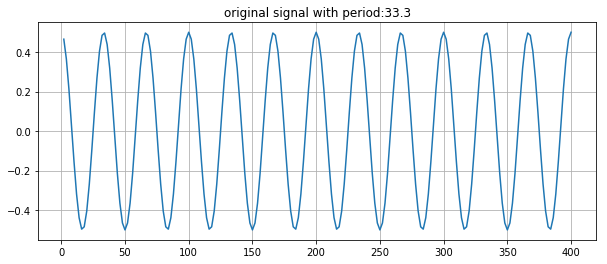

In [673]:
#creating data for testing
dt = 2
t = np.arange(1,200+1)*dt
amp = 0.5
f = 0.03
t_period = 1/f
x0 =amp*np.cos(2*np.pi*f*t);

fig, ax = plt.subplots(1,figsize=(10,4))
plt.plot(t,x0)
plt.title("original signal with period:{:.1f}".format(t_period))
plt.grid()
plt.show()

### using bandpass normalisation (since looking at magnitude rather than energy content)
- varying $\beta$ (for larger/narrower bandpass filter in the frequency domain)
- varying D (for less/more overlap between successive wavelets) 
- higher $\beta$ and higher D should yield better results (finer bandpass and more overlap)

/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in subtract
  if sys.path[0] == '':
/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  
/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log
/Users/jemimarama/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:2809: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)
/Users/jemimarama/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


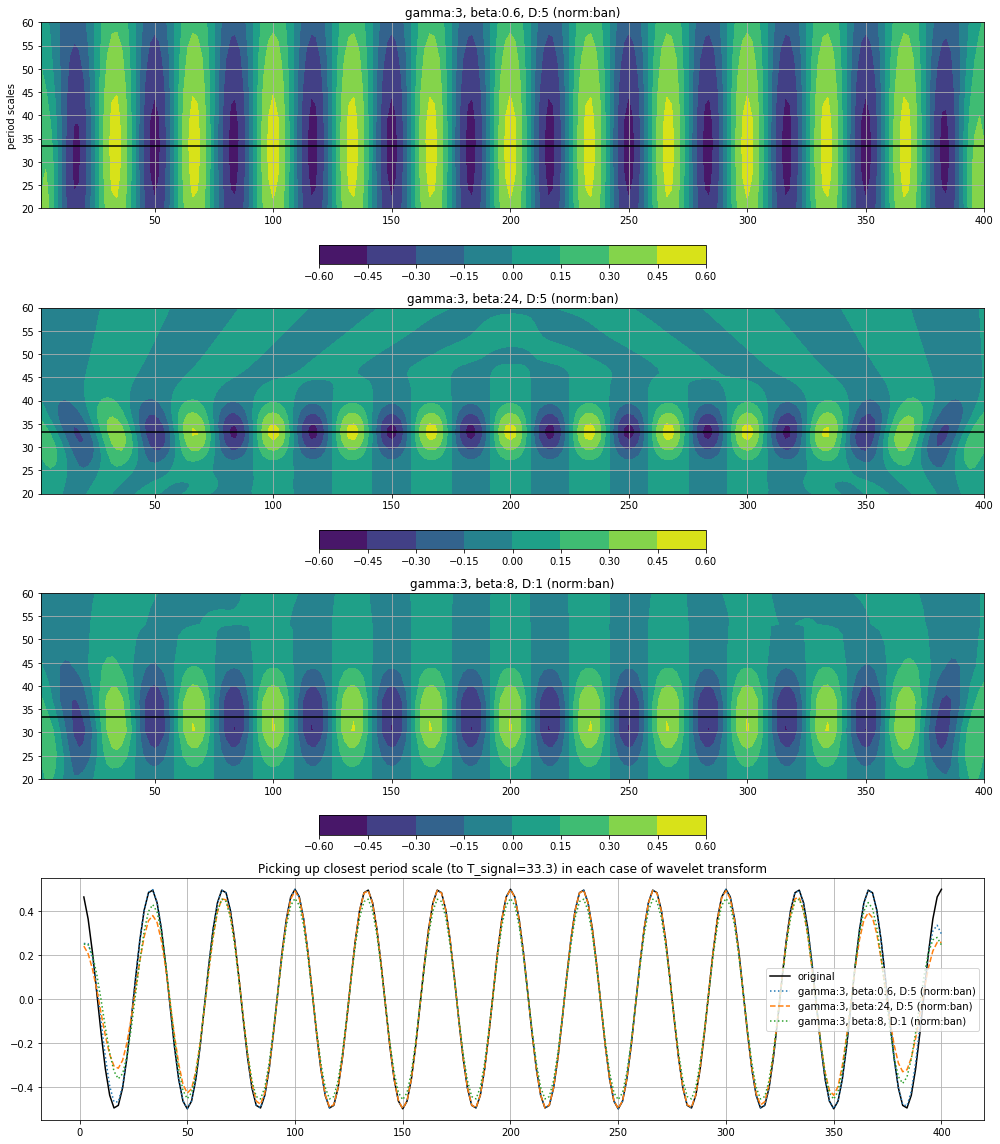

In [674]:
#zero pad for boundaries 
x = zero_pad(x0)
M = len(x)
str='ban' #type of normalisation, bandpass or via energy 

fig, ax = plt.subplots(4,1,figsize=(14,16))
ax[3].plot(t,x0,label="original",color="k")

#get wavelet shape 
ga = 3
be=0.6
K=1
D=5

#compute wavelet transform
WT = wavetrans(x0,ga,be,D,K,str)
fs = morsespace(ga,be,M,D)
t_scale = frequency_to_period(dt,fs)
ind_period = np.where(np.abs(t_scale-t_period) == np.min(np.abs(t_scale-t_period)))[0][0]

fig0 = ax[0].contourf(t,t_scale,np.transpose(WT))
ax[0].axhline(y=t_period,color="k")
ax[0].set_ylabel("period scales")

fig.colorbar(fig0,ax=ax[0],orientation="horizontal",fraction=0.08)
ax[0].set_ylim(20,60)
ax[0].set_title("gamma:{}, beta:{}, D:{} (norm:{})".format(ga,be,D,str))
ax[0].grid()
ax[3].plot(t,WT[:,ind_period],linestyle=":",label="gamma:{}, beta:{}, D:{} (norm:{})".format(ga,be,D,str))

#get wavelet shape 
ga = 3
be=24
K=1
D=5

#compute wavelet transform
WT = wavetrans(x0,ga,be,D,K,str)
fs = morsespace(ga,be,M,D)
t_scale = frequency_to_period(dt,fs)
ind_period = np.where(np.abs(t_scale-t_period) == np.min(np.abs(t_scale-t_period)))[0][0]


fig1 = ax[1].contourf(t,t_scale,np.transpose(WT))
fig.colorbar(fig1,ax=ax[1],orientation="horizontal",fraction=0.08)
ax[1].axhline(y=t_period,color="k")
ax[1].set_ylim(20,60)
ax[1].set_title("gamma:{}, beta:{}, D:{} (norm:{})".format(ga,be,D,str))
ax[1].grid()
ax[3].plot(t,WT[:,ind_period],linestyle="--",label="gamma:{}, beta:{}, D:{} (norm:{})".format(ga,be,D,str))


#get wavelet shape 
ga = 3
be=8
K=1
D=1

#compute wavelet transform
WT = wavetrans(x0,ga,be,D,K,str)
fs = morsespace(ga,be,M,D)
t_scale = frequency_to_period(dt,fs)
ind_period = np.where(np.abs(t_scale-t_period) == np.min(np.abs(t_scale-t_period)))[0][0]


fig2 = ax[2].contourf(t,t_scale,np.transpose(WT))
fig.colorbar(fig2,ax=ax[2],orientation="horizontal",fraction=0.08)
ax[2].axhline(y=t_period,color="k")
ax[2].set_ylim(20,60)
ax[2].set_title("gamma:{}, beta:{}, D:{} (norm:{})".format(ga,be,D,str))
ax[2].grid()
ax[3].plot(t,WT[:,ind_period],linestyle=":",label="gamma:{}, beta:{}, D:{} (norm:{})".format(ga,be,D,str))

ax[3].set_title("Picking up closest period scale (to T_signal={:.1f}) in each case of wavelet transform".format(t_period))
ax[3].legend()
ax[3].grid()

plt.tight_layout()
plt.show()

### Remarks
- Bottom pannel plots the ***wavelet transform*** (band pass filtered signal) at each scale - adding up all the wavelet transforms does not recover signal due to non-orthogonality of wavelet 


- Higher values of both $\beta$ and D capture the correct period (wavelet transform is centred around signal's period)
- Higher overlap between wavelet (higher values of D) captures signal's amplitude better (even when $\beta$ is small)

#### How well does the wavelet transform recover the signal?
- If dominant frequency is not known (unlike in this case whereby we are searching for a specific frequency/period), ***thresholding*** can be used 
- Compare wavelet transform (WT) with original signal, ratio (WT:original signal) closest to 1 gives dominant frequency
- Edge effects can be seen when comparing wavelet transform with original signal (see figure below)

/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in subtract
  if sys.path[0] == '':
/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  
/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log
/Users/jemimarama/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


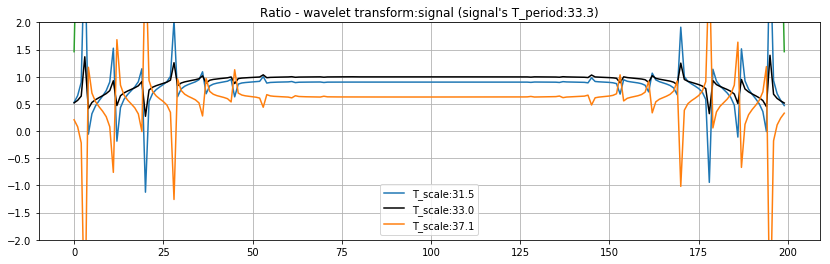

In [699]:
#get wavelet shape 
ga = 3
be=24
K=1
D=5

#compute wavelet transform
WT = wavetrans(x0,ga,be,D,K,str)
fs = morsespace(ga,be,M,D)
t_scale = frequency_to_period(dt,fs)
ind_period = np.where(np.abs(t_scale-t_period) == np.min(np.abs(t_scale-t_period)))[0][0]

fig, ax = plt.subplots(1,figsize=(14,4))
plt.plot((WT[:,ind_period-2]/x0),label="T_scale:{:.1f}".format(t_scale[ind_period-2]))
plt.plot((WT[:,ind_period]/x0),color="k",label="T_scale:{:.1f}".format(t_scale[ind_period]))
plt.plot((WT[:,ind_period+5]/x0),label="T_scale:{:.1f}".format(t_scale[ind_period+5]))
plt.plot(test_coi)

plt.title("Ratio - wavelet transform:signal (signal's T_period:{:.1f})".format(t_period))
plt.ylim(-2,2)
plt.legend()
plt.grid()
plt.show()

### Cone of influence 
- region within which wavelet coefficients are contaminated by edge effects
- Fourier transform assumes that data is cyclic - errors occur at beginnning and end of the WT
- Solution when dealing with finite-length time series:
        1) Pad signal's boundaries with zeros (specified above)
        2) Apply a cosine damping 
        3) Wrap around beginning and end of the signal
        
- Padding with zeroes still introduces discontinuities as endpoints and dcreases the amplitude near the edges  
- ***e-folding time*** ensures that edge effects are negligible beyond this point 
- e-folding time is chosen so that the wavelet power for a discontinuity at the edge drops by a factor ${e^{−2}}$
- the e-folding time is different for each wavelet basis (Torrence and Compo, 1998 - Table 1)

***Defining COI for Morlet wavelet instead (obviously not correct) - need to define COI for Morse wavelet that is being used for the WT***

- first define e-folding time equation
- e-folding time equation will have to depend on $\beta$ and $\gamma$
- if initial input data is made cyclic, then COI might not be an issue

In [706]:
#here using COI as defined for Morlet wavelet in Torrence and Compo (1998)
# COI returns a vector of N points containing the maximum Fourier period of useful
#information at that particular time. Periods greater than those are subject to edge effects
n0 = len(x0)
flambda = (4*np.pi)/(6+np.sqrt(2+36))
coi = (n0 / 2 - np.abs(np.arange(0, n0) - (n0 - 1) / 2)) #triangular Bartlett window 
e_fold = np.sqrt(2)
test_coi = flambda*dt*coi*e_fold

/Users/jemimarama/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:2809: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


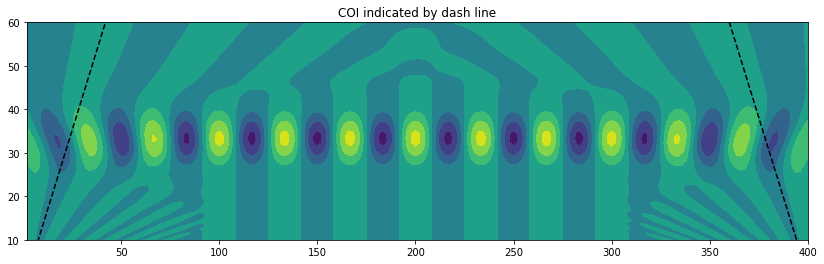

In [708]:
fig, ax = plt.subplots(1,figsize=(14,4))
plt.contourf(t,t_scale,np.transpose(WT))
plt.plot(t,test_coi,color="k",linestyle="--")
plt.ylim(10,60)
plt.title("COI indicated by dash line")
plt.show()


### Case 2: Low frequency sinusoid 
- Higher values of $\beta$ (narrower frequency -domain wavelet) should not be able to resolve low frequency signal

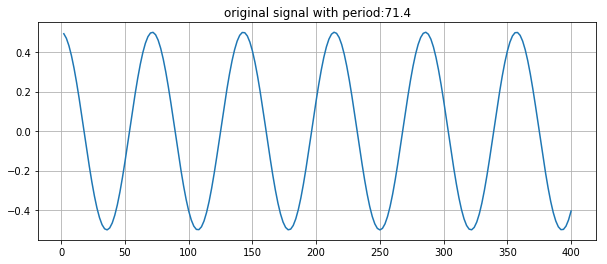

In [462]:
#creating data for testing
dt = 2
t = np.arange(1,200+1)*dt
amp = 0.5
f = 0.014
t_period = 1/f
x0 =amp*np.cos(2*np.pi*f*t);

fig, ax = plt.subplots(1,figsize=(10,4))
plt.plot(t,x0)
plt.title("original signal with period:{:.1f}".format(t_period))
plt.grid()
plt.show()

/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in subtract
  if sys.path[0] == '':
/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  
/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log


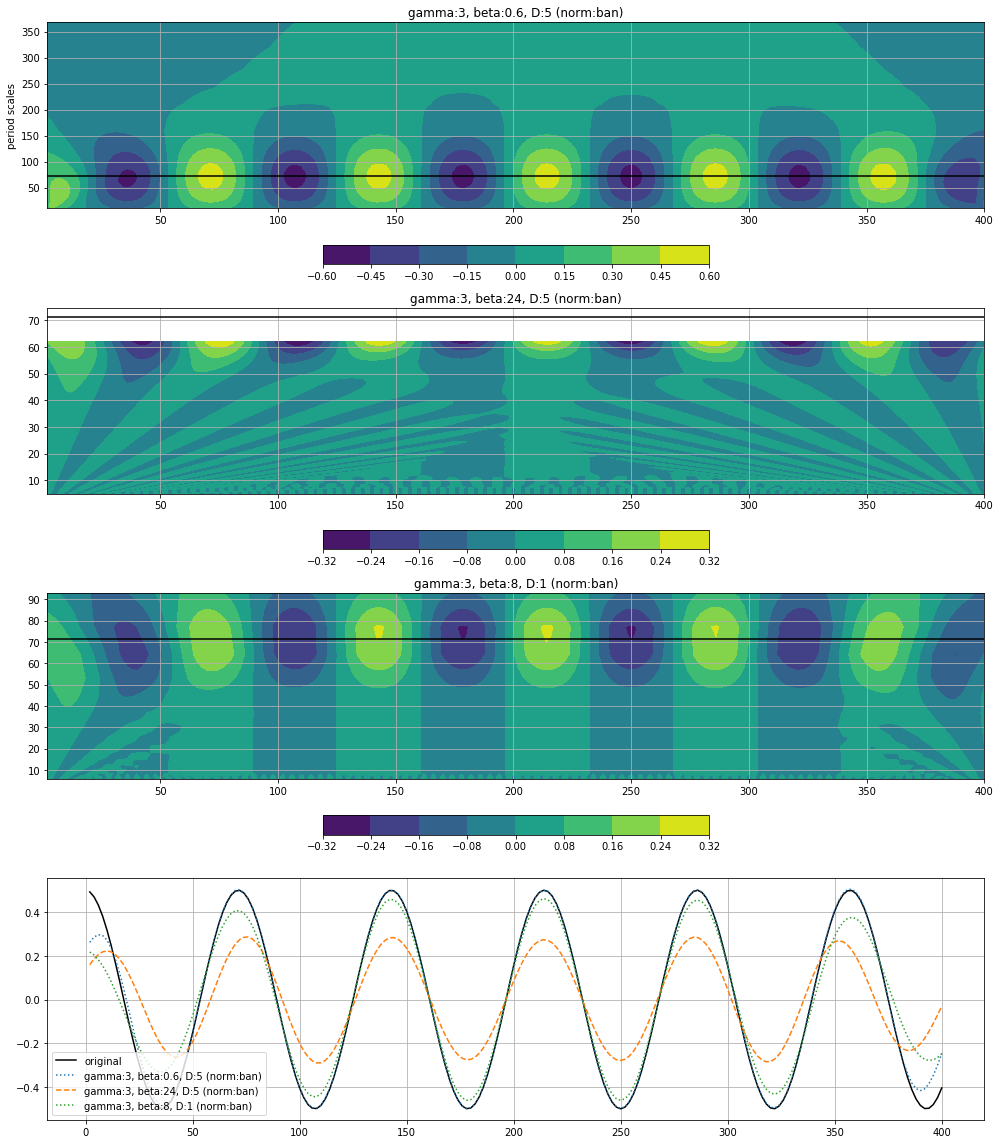

In [463]:
#zero pad for boundaries 
x = zero_pad(x0)
M = len(x)
str='ban' #type of normalisation, bandpass or via energy 

fig, ax = plt.subplots(4,1,figsize=(14,16))
ax[3].plot(t,x0,label="original",color="k")

#get wavelet shape 
ga = 3
be=0.6
K=1
D=5

#compute wavelet transform
WT = wavetrans(x0,ga,be,D,K,str)
fs = morsespace(ga,be,M,D)
t_scale = frequency_to_period(dt,fs)
ind_period = np.where(np.abs(t_scale-t_period) == np.min(np.abs(t_scale-t_period)))[0][0]

fig0 = ax[0].contourf(t,t_scale,np.transpose(WT))
ax[0].axhline(y=t_period,color="k")
ax[0].set_ylabel("period scales")

fig.colorbar(fig0,ax=ax[0],orientation="horizontal",fraction=0.08)
#ax[0].set_ylim(0,200)
ax[0].set_title("gamma:{}, beta:{}, D:{} (norm:{})".format(ga,be,D,str))
ax[0].grid()
ax[3].plot(t,WT[:,ind_period],linestyle=":",label="gamma:{}, beta:{}, D:{} (norm:{})".format(ga,be,D,str))

#get wavelet shape 
ga = 3
be=24
K=1
D=5

#compute wavelet transform
WT = wavetrans(x0,ga,be,D,K,str)
fs = morsespace(ga,be,M,D)
t_scale = frequency_to_period(dt,fs)
ind_period = np.where(np.abs(t_scale-t_period) == np.min(np.abs(t_scale-t_period)))[0][0]


fig1 = ax[1].contourf(t,t_scale,np.transpose(WT))
fig.colorbar(fig1,ax=ax[1],orientation="horizontal",fraction=0.08)
ax[1].axhline(y=t_period,color="k")
#ax[1].set_ylim(0,200)
ax[1].set_title("gamma:{}, beta:{}, D:{} (norm:{})".format(ga,be,D,str))
ax[1].grid()
ax[3].plot(t,WT[:,ind_period],linestyle="--",label="gamma:{}, beta:{}, D:{} (norm:{})".format(ga,be,D,str))


#get wavelet shape 
ga = 3
be=8
K=1
D=1

#compute wavelet transform
WT = wavetrans(x0,ga,be,D,K,str)
fs = morsespace(ga,be,M,D)
t_scale = frequency_to_period(dt,fs)
ind_period = np.where(np.abs(t_scale-t_period) == np.min(np.abs(t_scale-t_period)))[0][0]


fig2 = ax[2].contourf(t,t_scale,np.transpose(WT))
fig.colorbar(fig1,ax=ax[2],orientation="horizontal",fraction=0.08)
ax[2].axhline(y=t_period,color="k")
#ax[2].set_ylim(0,200)
ax[2].set_title("gamma:{}, beta:{}, D:{} (norm:{})".format(ga,be,D,str))
ax[2].grid()
ax[3].plot(t,WT[:,ind_period],linestyle=":",label="gamma:{}, beta:{}, D:{} (norm:{})".format(ga,be,D,str))

#ax[3].set_title("Picking up closest period scale (to T_signal={}) in each case of wavelet transform".format())
ax[3].legend()
ax[3].grid()

plt.tight_layout()
plt.show()

### Remarks
- Lower values of $\beta$ (larger wavelets/bandpass filters) capture the correct period for low frequency signal


### Case 3: Combination of 2 sinusoids (with different frequencies and amplitudes)

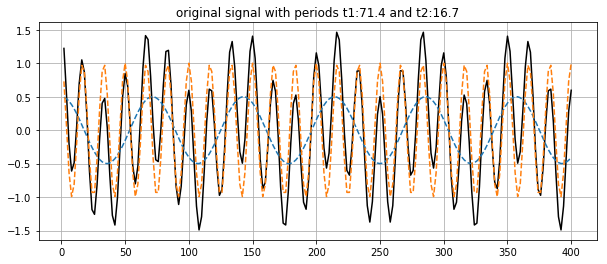

In [709]:
#creating data for testing
dt = 2
t = np.arange(1,200+1)*dt
N=len(t)
amp1 = 0.5
f1 = 0.014
t1_period = 1/f1
x1 =amp1*np.cos(2*np.pi*f1*t);

amp2 = 1
f2 = 0.06
t2_period = 1/f2
x2 = amp2*np.cos(2*np.pi*f2*t);

x0 = x1 + x2

fig, ax = plt.subplots(1,figsize=(10,4))
plt.plot(t,x0,color="k")
plt.plot(t,x1,linestyle="--")
plt.plot(t,x2,linestyle="--")
plt.title("original signal with periods t1:{:.1f} and t2:{:.1f}".format(t1_period,t2_period))
plt.grid()
plt.show()

/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in subtract
  if sys.path[0] == '':
/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  
/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log
/Users/jemimarama/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:2809: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


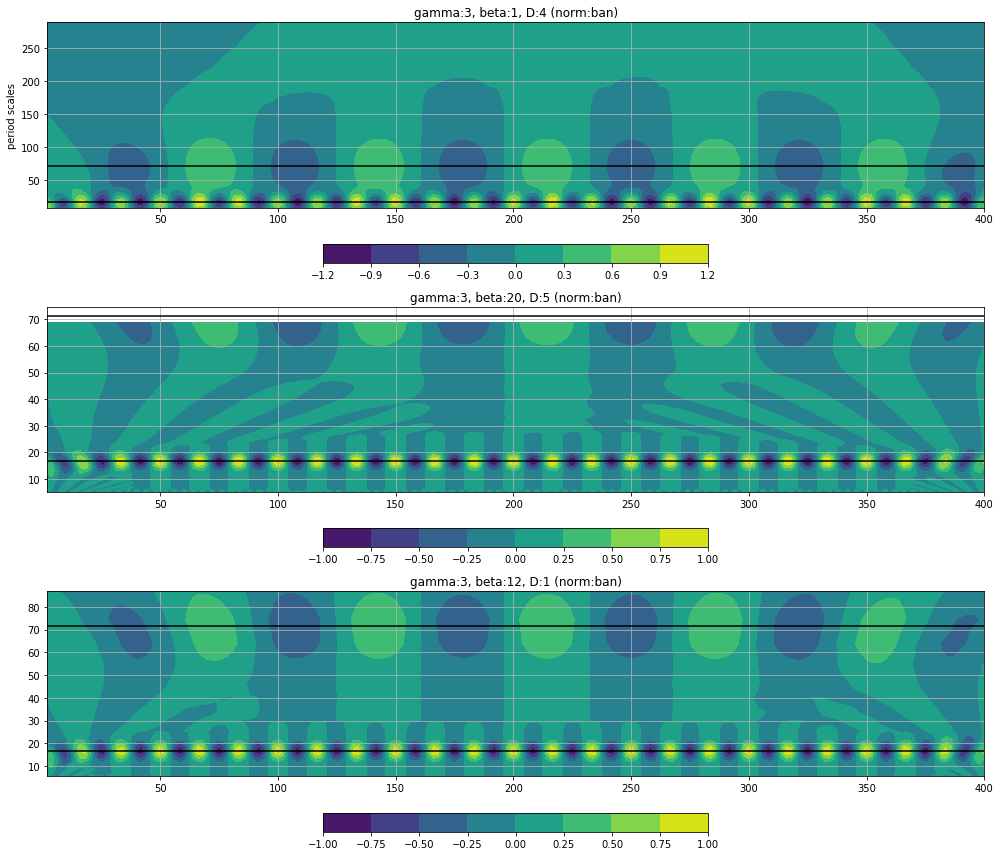

In [733]:
#zero pad for boundaries 
x = zero_pad(x0)
M = len(x)
str='ban' #type of normalisation, bandpass or via energy 

fig, ax = plt.subplots(3,1,figsize=(14,12))


#get wavelet shape 
ga = 3
be=1
K=1
D=4

#compute wavelet transform
WT = wavetrans(x0,ga,be,D,K,str)
fs = morsespace(ga,be,M,D)
t_scale = frequency_to_period(dt,fs)

fig0 = ax[0].contourf(t,t_scale,np.transpose(WT))
ax[0].axhline(y=t1_period,color="k")
ax[0].axhline(y=t2_period,color="k")
ax[0].set_ylabel("period scales")

fig.colorbar(fig0,ax=ax[0],orientation="horizontal",fraction=0.08)
ax[0].set_title("gamma:{}, beta:{}, D:{} (norm:{})".format(ga,be,D,str))
ax[0].grid()

#get wavelet shape 
ga = 3
be=20
K=1
D=5

#compute wavelet transform
WT = wavetrans(x0,ga,be,D,K,str)
fs = morsespace(ga,be,M,D)
t_scale = frequency_to_period(dt,fs)



fig1 = ax[1].contourf(t,t_scale,np.transpose(WT))
fig.colorbar(fig1,ax=ax[1],orientation="horizontal",fraction=0.08)
ax[1].axhline(y=t1_period,color="k")
ax[1].axhline(y=t2_period,color="k")
ax[1].set_title("gamma:{}, beta:{}, D:{} (norm:{})".format(ga,be,D,str))
ax[1].grid()

#get wavelet shape 
ga = 3
be=12

K=1
D=1

#compute wavelet transform
WT = wavetrans(x0,ga,be,D,K,str)
fs = morsespace(ga,be,M,D)
t_scale = frequency_to_period(dt,fs)
ind_period = np.where(np.abs(t_scale-t_period) == np.min(np.abs(t_scale-t_period)))[0][0]


fig2 = ax[2].contourf(t,t_scale,np.transpose(WT))
fig.colorbar(fig1,ax=ax[2],orientation="horizontal",fraction=0.08)
ax[2].axhline(y=t1_period,color="k")
ax[2].axhline(y=t2_period,color="k")
ax[2].set_title("gamma:{}, beta:{}, D:{} (norm:{})".format(ga,be,D,str))
ax[2].grid()


plt.tight_layout()
plt.show()

#### Quick picutre: Power spectrum of data and frequency domain wavelets used

/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log


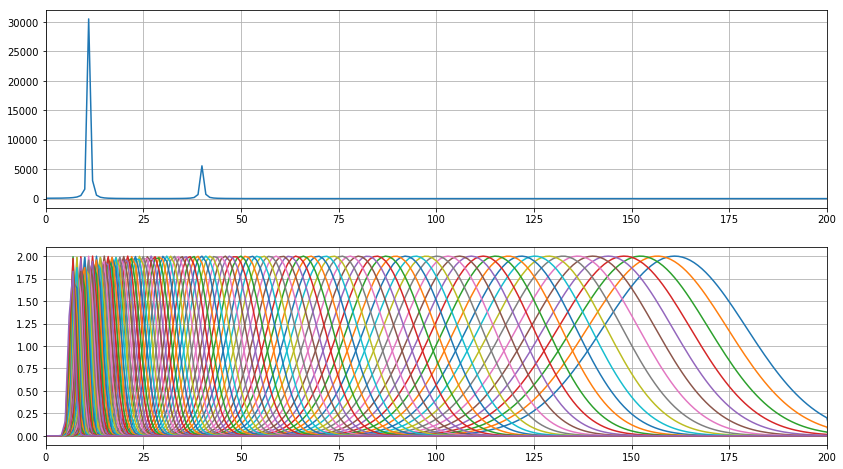

In [770]:
N=len(x0)
xhat = np.fft.fft(x0)
psif = morsewave(N,K,ga,be,fs,str)

fig, ax = plt.subplots(2,1,figsize=(14,8))
ax[0].plot(np.abs(xhat)**2)
ax[0].set_xlim(0,200)
ax[0].grid()

ax[1].plot(psif)
ax[1].set_xlim(0,200)
ax[1].grid()
plt.show()


### Statistical significance
#### Using Thresholding to extract statistically significant coefficients
- first get region outside cone of influence (below crude way - merely extracting setion of WT that is away from the edges)
- compute ratio (or percentage) between wavelet transform and original signal
- keep wavelet transform closest to 100% of the signal?

#### Here extracting dominant frequency scale


In [727]:
def return_dominant_fs_ind(data,WT):
    #data is the original signal
    #WT is series of wavelet transforms
    
    WT_COI = WT[int((N/2)-50):int((N/2)+50),:]
    data = data[int((N/2)-50):int((N/2)+50)]

    threshold  = np.zeros(len(t_scale))
    for ii in np.arange(len(t_scale)):
        ratio = np.real(WT_COI[:,ii])/data
        ratio_mean = np.mean(ratio) #compute mean ratio along time series
        threshold[ii] = ratio_mean
    
    #find index of dominant frequency scale
    ind_dominant = np.where(np.abs(threshold-1) == np.min(np.abs(threshold-1)))[0][0]
    
    return(ind_dominant)
    

/Users/jemimarama/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


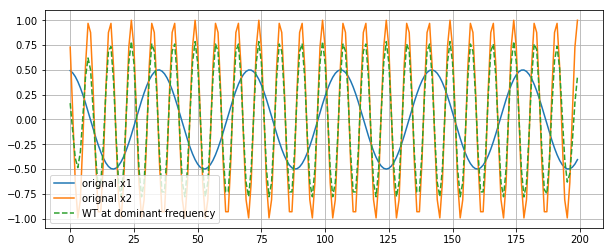

In [728]:
ind_dominant = return_dominant_fs_ind(x0,WT)
fig, ax = plt.subplots(1,figsize=(10,4))\
#plt.plot(x0,label="original signal")
plt.plot(x1,label="orignal x1")
plt.plot(x2,label="orignal x2")


plt.plot(WT[:,ind_dominant],label="WT at dominant frequency",linestyle="--")

plt.legend()
plt.grid()
plt.show()

#### Additional step: wavelet transform power spectrum can be compared to a white noise power spectrum for significance levels (using Monte Carlo simulations with 95% confidence)- check other notebook

### Case 4: Decaying signal

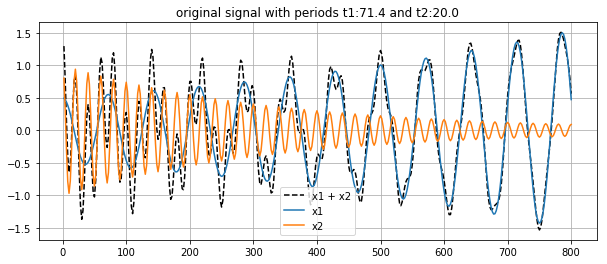

In [768]:
#creating data for testing
dt = 2
t = np.arange(1,400+1)*dt
N=len(t)
amp1 = 0.5
f1 = 0.014
t1_period = 1/f1
x1 =amp1*np.cos(2*np.pi*f1*t)*np.exp(1.4e-3*t);

amp2 = 1
f2 = 0.05
t2_period = 1/f2
x2 = amp2*np.cos(2*np.pi*f2*t)*np.exp(-0.3e-2*t);

x0 = x1 + x2

fig, ax = plt.subplots(1,figsize=(10,4))
plt.plot(t,x0,color="k",linestyle="--",label="x1 + x2")
plt.plot(t,x1,linestyle="-",label="x1")
plt.plot(t,x2,linestyle="-",label="x2")
plt.title("original signal with periods t1:{:.1f} and t2:{:.1f}".format(t1_period,t2_period))
plt.grid()
plt.legend()
plt.show()

/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in subtract
  if sys.path[0] == '':
/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  
/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log
/Users/jemimarama/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:2809: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


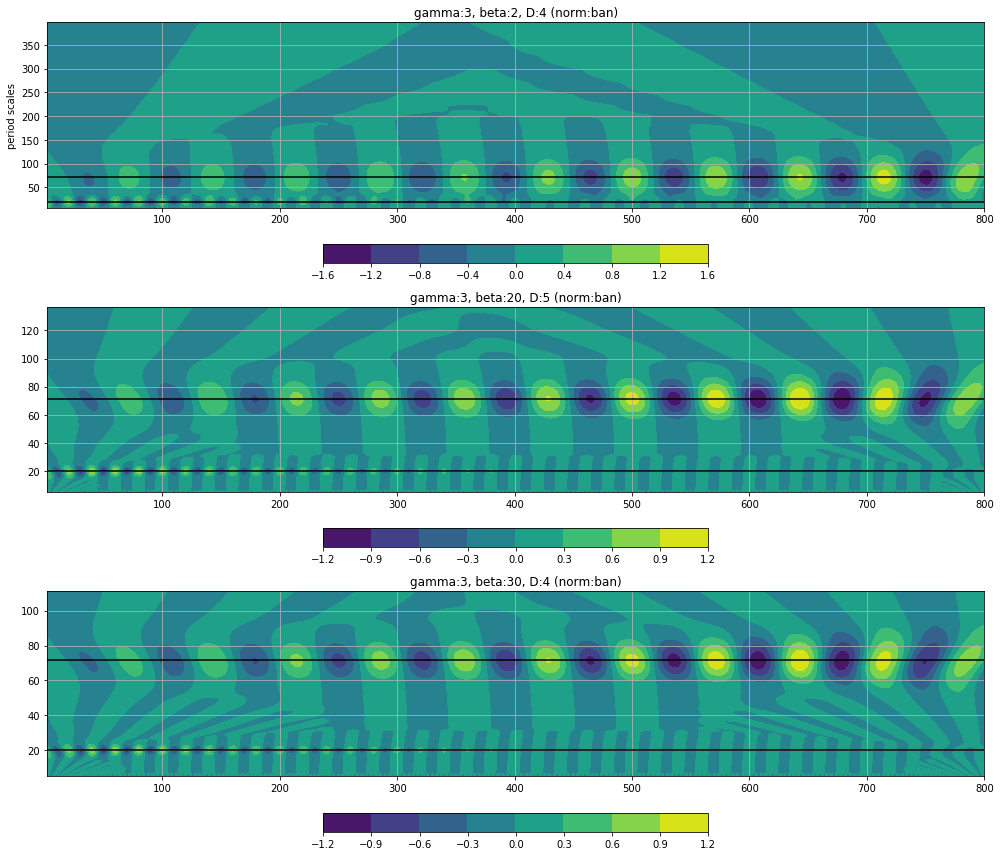

In [771]:
#zero pad for boundaries 
x = zero_pad(x0)
M = len(x)
str='ban' #type of normalisation, bandpass or via energy 

fig, ax = plt.subplots(3,1,figsize=(14,12))


#get wavelet shape 
ga = 3
be=2
K=1
D=4

#compute wavelet transform
WT = wavetrans(x0,ga,be,D,K,str)
fs = morsespace(ga,be,M,D)
t_scale = frequency_to_period(dt,fs)

fig0 = ax[0].contourf(t,t_scale,np.transpose(WT))
ax[0].axhline(y=t1_period,color="k")
ax[0].axhline(y=t2_period,color="k")
ax[0].set_ylabel("period scales")

fig.colorbar(fig0,ax=ax[0],orientation="horizontal",fraction=0.08)
ax[0].set_title("gamma:{}, beta:{}, D:{} (norm:{})".format(ga,be,D,str))
ax[0].grid()

#get wavelet shape 
ga = 3
be=20
K=1
D=5

#compute wavelet transform
WT = wavetrans(x0,ga,be,D,K,str)
fs = morsespace(ga,be,M,D)
t_scale = frequency_to_period(dt,fs)



fig1 = ax[1].contourf(t,t_scale,np.transpose(WT))
fig.colorbar(fig1,ax=ax[1],orientation="horizontal",fraction=0.08)
ax[1].axhline(y=t1_period,color="k")
ax[1].axhline(y=t2_period,color="k")
ax[1].set_title("gamma:{}, beta:{}, D:{} (norm:{})".format(ga,be,D,str))
ax[1].grid()

#get wavelet shape 
ga = 3
be=30

K=1
D=4

#compute wavelet transform
WT = wavetrans(x0,ga,be,D,K,str)
fs = morsespace(ga,be,M,D)
t_scale = frequency_to_period(dt,fs)
ind_period = np.where(np.abs(t_scale-t_period) == np.min(np.abs(t_scale-t_period)))[0][0]


fig2 = ax[2].contourf(t,t_scale,np.transpose(WT))
fig.colorbar(fig1,ax=ax[2],orientation="horizontal",fraction=0.08)
ax[2].axhline(y=t1_period,color="k")
ax[2].axhline(y=t2_period,color="k")
ax[2].set_title("gamma:{}, beta:{}, D:{} (norm:{})".format(ga,be,D,str))
ax[2].grid()


plt.tight_layout()
plt.show()

#### Remarks:
- Growth of signal with longer period (x1) captured well (wavelets seem to pick up signal with larger ampltiude)
- Decay of signal with shorter period (x2) not captured so well (as x2 decays, its smaller amplitude is not captures as well by the wavelets


#### Further check to ensuring that wavelet has extracted proper signal
- Adjust choice of $\beta$ such that spectrum of residual shows that peak has been effectively removed (when plotting frequency spectrum)


### Case 4: Step function (Boxcar function)

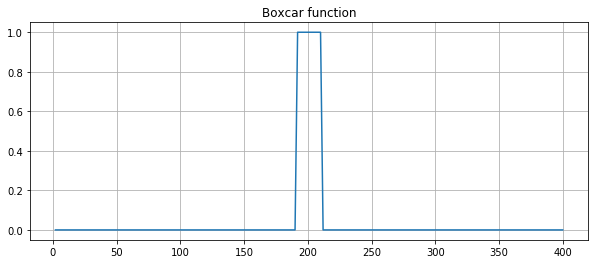

In [353]:
# creating boxcar function
x0 = np.zeros(len(t))
x0[int(len(x0)/2-5):int(len(x0)/2+5)]=1
fig, ax = plt.subplots(1,figsize=(10,4))
plt.plot(t,x0)
plt.title("Boxcar function")
plt.grid()
plt.show()

/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in subtract
  if sys.path[0] == '':
/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  
/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log


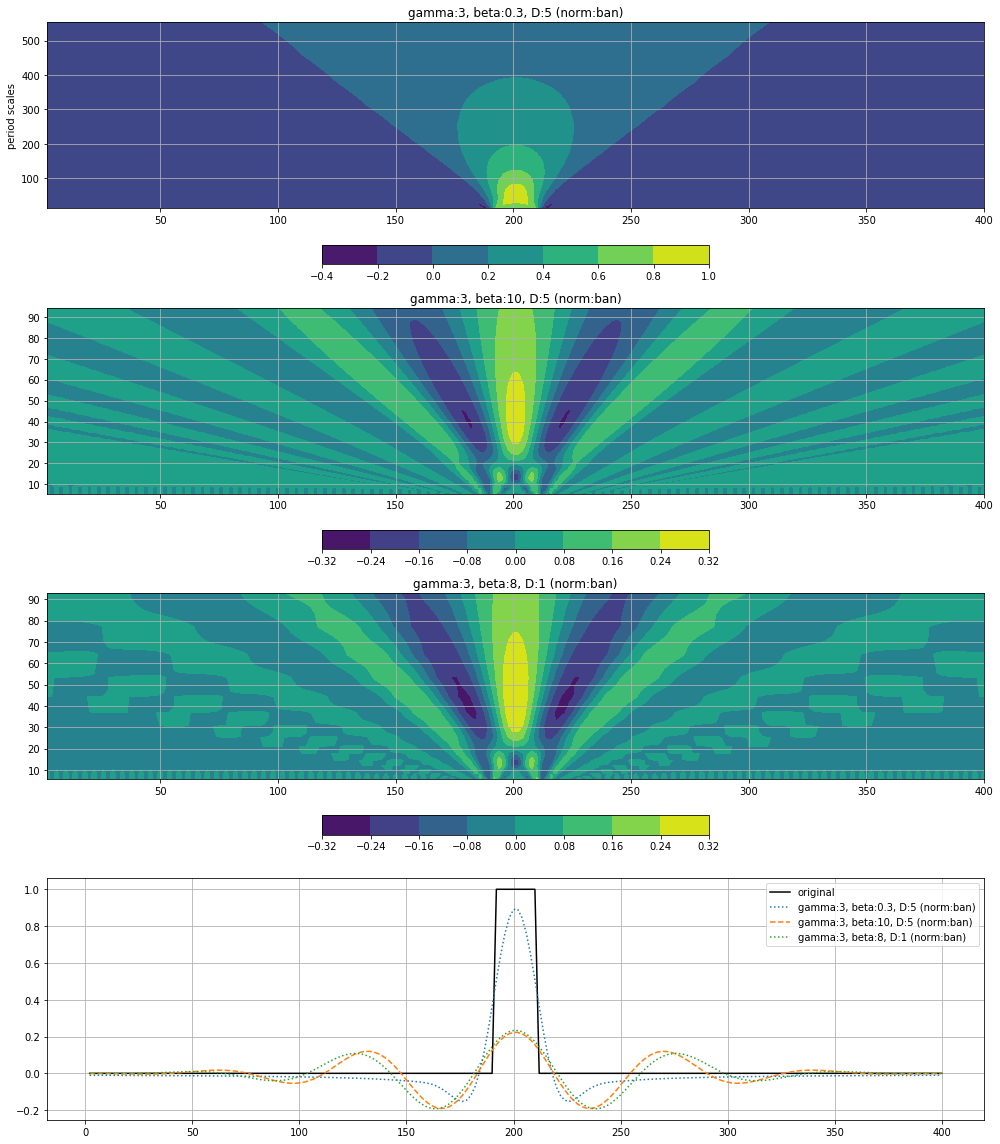

In [352]:
#zero pad for boundaries 
x = zero_pad(x0)
M = len(x)
str='ban' #type of normalisation, bandpass or via energy 

fig, ax = plt.subplots(4,1,figsize=(14,16))
ax[3].plot(t,x0,label="original",color="k")

#get wavelet shape 
ga = 3
be=0.3
K=1
D=5

#compute wavelet transform
WT = wavetrans(x0,ga,be,D,K,str)
fs = morsespace(ga,be,M,D)
t_scale = frequency_to_period(dt,fs)
ind_period = np.where(np.abs(t_scale-t_period) == np.min(np.abs(t_scale-t_period)))[0][0]

fig0 = ax[0].contourf(t,t_scale,np.transpose(WT))
#ax[0].axhline(y=t_period,color="k")
ax[0].set_ylabel("period scales")

fig.colorbar(fig0,ax=ax[0],orientation="horizontal",fraction=0.08)
#ax[0].set_ylim(0,200)
ax[0].set_title("gamma:{}, beta:{}, D:{} (norm:{})".format(ga,be,D,str))
ax[0].grid()
ax[3].plot(t,WT[:,ind_period],linestyle=":",label="gamma:{}, beta:{}, D:{} (norm:{})".format(ga,be,D,str))

#get wavelet shape 
ga = 3
be=10
K=1
D=5

#compute wavelet transform
WT = wavetrans(x0,ga,be,D,K,str)
fs = morsespace(ga,be,M,D)
t_scale = frequency_to_period(dt,fs)
ind_period = np.where(np.abs(t_scale-t_period) == np.min(np.abs(t_scale-t_period)))[0][0]


fig1 = ax[1].contourf(t,t_scale,np.transpose(WT))
fig.colorbar(fig1,ax=ax[1],orientation="horizontal",fraction=0.08)
#ax[1].axhline(y=t_period,color="k")
#ax[1].set_ylim(0,200)
ax[1].set_title("gamma:{}, beta:{}, D:{} (norm:{})".format(ga,be,D,str))
ax[1].grid()
ax[3].plot(t,WT[:,ind_period],linestyle="--",label="gamma:{}, beta:{}, D:{} (norm:{})".format(ga,be,D,str))


#get wavelet shape 
ga = 3
be=8
K=1
D=1

#compute wavelet transform
WT = wavetrans(x0,ga,be,D,K,str)
fs = morsespace(ga,be,M,D)
t_scale = frequency_to_period(dt,fs)
ind_period = np.where(np.abs(t_scale-t_period) == np.min(np.abs(t_scale-t_period)))[0][0]


fig2 = ax[2].contourf(t,t_scale,np.transpose(WT))
fig.colorbar(fig1,ax=ax[2],orientation="horizontal",fraction=0.08)
#ax[2].axhline(y=t_period,color="k")
#ax[2].set_ylim(0,200)
ax[2].set_title("gamma:{}, beta:{}, D:{} (norm:{})".format(ga,be,D,str))
ax[2].grid()
ax[3].plot(t,WT[:,ind_period],linestyle=":",label="gamma:{}, beta:{}, D:{} (norm:{})".format(ga,be,D,str))

#ax[3].set_title("Picking up closest period scale (to T_signal={}) in each case of wavelet transform".format())
ax[3].legend()
ax[3].grid()

plt.tight_layout()
plt.show()

***Remarks***
- discontinuous function such as a step function produces a set of maxima or ridges that cross various scales at the physical location of the discontinuity. Thus, it is a good candidate to demonstrate the uncertainty of the wavelet being used

### Deconstruction and reconstruction using wavelet transform
*** Reconstruction of original time series***
- For orthogonal wavelet bases (DWT)
    - reconstruction is done through inverse filter (ifft)
    
    
- For non-orthogonal wavelets (CWT - i.e Morse)
    - reconstruction cannot be done through "straightforward" inverse filter due to the redundancy in time and scale
    - however redundancy implies that reconstruction can be done using a completely different wavelet function (e.g delta (δ) function - Farge, 1992)

#### How to compute reconstruction factor?
- *** in another notebook***
- Empirically derived factors for different wavelet bases (Table 2, Torrence and Compo, 1998)
- Find reconstruction factor for different Morse wavelets?

#### The Heisenberg Area 
- Measure of time/frequency concentration
- resolution of a wavelet function is determined by the balance between the width in real space and the width in Fourier space
- Heisenberg area decreases with increasing ${\beta}$ for fixed $\gamma$


***Things to do***:
- define "cyclic" or "mirror option" for boundary conditions of input signal
- define COI for Morse wavelet 
- define morse wavelet for $\beta$=0
- specify options for high order Morse wavelets (K>1)
- define significance levels
